Target : Find a mapping so that m is equidistributed over the adapted mesh:
$$
m(\mathbf{x})det(\mathbf{J}) = \theta
$$

The deformation of the map can be expressed in terms of the gradient of a scalar potential $\phi$ such that:
$$
\mathbf{x}(\mathbf{\xi}) = \xi + \nabla_{\mathbf{\xi}}\phi(\mathbf{\xi})
$$

Give a nonlinear PDE of monge-Ampere type:
$$
m(\mathbf{x})det(\mathbf{I}+\mathbf{H}(\phi(\mathbf{\xi}))) = \theta
$$

# Dependence

In [275]:
import torch
import torch.nn as nn
import torch.autograd as autograd

import numpy as np 

from pyDOE import lhs

import matplotlib.pyplot as plt
import matplotlib.tri as mtri

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameter

In [276]:
steps = 10000
layers = np.array([2,32,64,32,1])
lr = 0.01

Nf = 10000  # samples for the PDE loss

# Auxiliary Functions


In [277]:
def Plot(V,tris,U):
    _,ax=plt.subplots()
    ax.tripcolor(V[:,0],V[:,1],tris,U,cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('U')
    plt.show()

# Build initial physical mesh and logical mesh

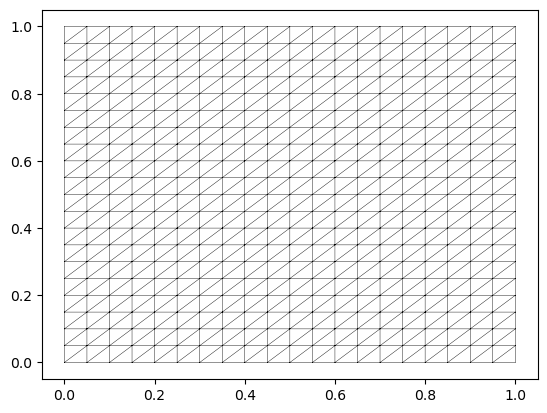

In [278]:
m_rows = 20
m_cols = 20

x = torch.linspace(0, 1, m_cols + 1)
y = torch.linspace(0, 1, m_rows + 1)
x = x.repeat(m_rows + 1)
y = y.repeat_interleave(m_cols + 1)
V_0 = torch.stack([x,y],dim=1) #physical mesh
V_xi_0 = V_0.clone() #logical mesh

tris = []

for i in range(m_cols):
   for j in range(m_rows):
       tris.append([j * (m_cols + 1) + i, j * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i + 1])
       tris.append([j * (m_cols + 1) + i, (j + 1) * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i])
        
tris = torch.tensor(tris, dtype=torch.short)

plt.triplot(x,y,tris,'k-',linewidth=0.3)
plt.show()

# Field functions

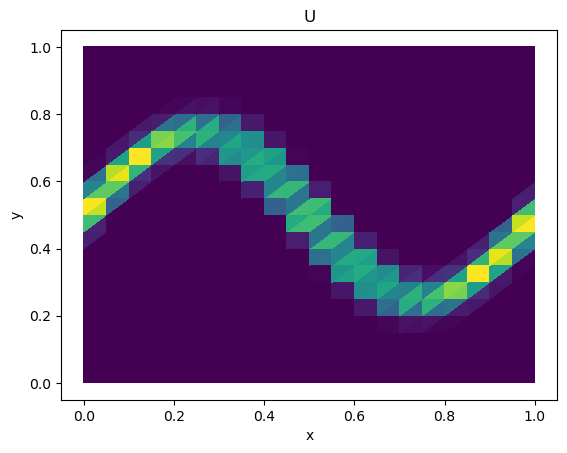

In [279]:
def U(V):
    return torch.tanh(-30*(V[:,1]-0.5-0.25*torch.sin(2*torch.pi*V[:,0])))

def U_x_y(V):
    U_x = (1-U(V)**2)*(15*torch.pi*torch.cos(2*torch.pi*V[:,0]))
    U_y = (1-U(V)**2)*(-30)
    return torch.stack([U_x,U_y],dim=1)

def Metric(V):
    u_x_y = U_x_y(V)
    return torch.sqrt(0.1*torch.linalg.norm(u_x_y,dim=1)**2 + 1)

M = Metric(V_0)
Plot(V_0.detach().cpu(),tris.detach().cpu(),M.detach().cpu())

# Training Data

In [280]:
left_V = V_0[(V_0[:,0]==0.0)]
right_V = V_0[(V_0[:,0]==1.0)]
bottom_V = V_0[(V_0[:,1]==0.0)]
top_V = V_0[(V_0[:,1]==1.0)]
Boundary_V = torch.vstack((left_V,right_V,bottom_V,top_V))

PDE_V = V_0[0] + (V_0[-1]-V_0[0])*lhs(2,Nf)
PDE_V = torch.vstack((Boundary_V,PDE_V))

V_0 = V_0.to(device)
V_xi_0 = V_xi_0.to(device)
Boundary_V = Boundary_V.float().to(device)
PDE_V = PDE_V.float().to(device)


C:\Users\13162\AppData\Local\Temp\ipykernel_28448\3163545425.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  PDE_V = V_0[0] + (V_0[-1]-V_0[0])*lhs(2,Nf)


# Neural Network 


In [ ]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.loss_function2 = nn.L1Loss(reduction ='sum')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)   

    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)
        xi = torch.cos(torch.pi*x[:,[0]])         # used to keep boundary conditions       
        eta = torch.cos(torch.pi*x[:,[1]])
        a = torch.cat((xi,eta),dim=1)
        for i in range(len(self.layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)
        a = self.linears[-1](a)
        return a
    
    def loss_BC(self,Boundary_V):
        g = Boundary_V.clone()
        g.requires_grad = True
        f = self.forward(g)
        f_0_1 = autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),create_graph=True)[0]
        return self.loss_function2(f_0_1, torch.zeros(f_0_1.shape).to(device))
    
    def loss_PDE(self,PDE_V):
        g = PDE_V.clone()
        g.requires_grad = True
        f = self.forward(g)
        f_0_1 = autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        f_0 = f_0_1[:,[0]]
        f_1 = f_0_1[:,[1]]
        f_00_01 = autograd.grad(f_0,g,torch.ones([g.shape[0],1]).to(device),create_graph=True)[0]
        f_10_11 = autograd.grad(f_1,g,torch.ones([g.shape[0],1]).to(device),create_graph=True)[0]
        f_00 = f_00_01[:,[0]]
        f_01 = f_00_01[:,[1]]
        f_10 = f_10_11[:,[0]]
        f_11 = f_10_11[:,[1]]
        m = Metric(g + f_0_1).unsqueeze(1)
        detJ = (f_00+1)*(f_11+1)-f_01*f_10
        return self.loss_function(detJ * m, torch.ones(g.shape[0],1).to(device))

    def loss(self,Boundary_V,PDE_V):      
        return self.loss_PDE(PDE_V)
    
    def closure(self):
        optimizer_lbfgs.zero_grad()
        loss = self.loss(Boundary_V,PDE_V)
        loss.backward()
        self.iter += 1
        return loss

# Generate initial physical mesh

adam 0 49.187443
adam 10 23.288067
adam 11 12.585887
adam 52 11.5445175
adam 53 10.554163
adam 54 10.241764
adam 69 9.911486
adam 73 9.502633
adam 74 8.934068
adam 76 8.909728
adam 77 8.79749
adam 78 8.750211
adam 79 8.618753
adam 80 8.390936
adam 81 8.233363
adam 83 8.220711
adam 84 8.059903
adam 85 7.832928
adam 86 7.7043223
adam 87 7.6797533
adam 88 7.630459
adam 89 7.516212
adam 90 7.3637166
adam 91 7.26017
adam 92 7.2247868
adam 93 7.1585107
adam 94 7.0413446
adam 95 6.9413033
adam 96 6.876935
adam 97 6.8217115
adam 98 6.760984
adam 99 6.692235
adam 100 6.620845
adam 101 6.5570416
adam 102 6.506196
adam 103 6.4638314
adam 104 6.424306
adam 105 6.389156
adam 106 6.3609343
adam 107 6.333191
adam 108 6.297752
adam 109 6.255081
adam 110 6.2121167
adam 111 6.173361
adam 112 6.136853
adam 113 6.0984516
adam 114 6.0570445
adam 115 6.01607
adam 116 5.9803514
adam 117 5.95029
adam 118 5.921834
adam 119 5.8924866
adam 120 5.863784
adam 121 5.8376646
adam 122 5.812697
adam 123 5.7859454
adam

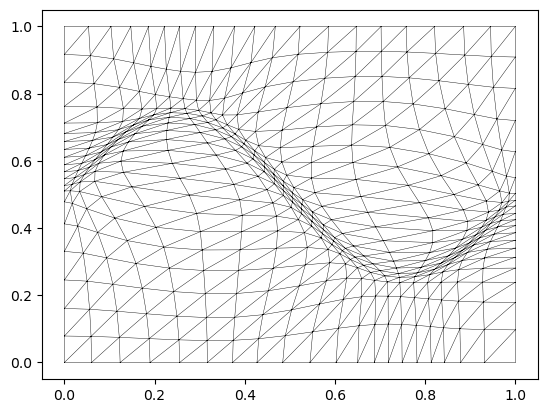

In [282]:
phi = FCN(layers).to(device)

best_loss = 1e10
adam_early_stop = 100
early_stop_count = 0
early_stop_step = 0
optimizer_adam = torch.optim.Adam(phi.parameters(),lr=lr,amsgrad=False)
for i in range(steps):
    loss = phi.loss(Boundary_V,PDE_V)
    optimizer_adam.zero_grad()
    loss.backward()
    optimizer_adam.step()
    if(loss.detach().cpu().numpy() < best_loss):
        best_loss = loss.detach().cpu().numpy()
        print('adam', i, best_loss)
        early_stop_count = 0
    else:
        early_stop_count += 1
    if early_stop_count > adam_early_stop:
        early_stop_step = i
        break
    
print('Adam early stopping at step:', early_stop_step)
optimizer_lbfgs = torch.optim.LBFGS(phi.parameters(), lr=1.0, max_iter=1, history_size=50)
for i in range(early_stop_step,steps):
    loss = optimizer_lbfgs.step(phi.closure)
    print('lbfgs', i, loss.detach().cpu().numpy())
    
V_xi_0_clone = V_xi_0.clone()
V_xi_0_clone.requires_grad = True
P = phi.forward(V_xi_0_clone)
P_0_1 = autograd.grad(P,V_xi_0_clone,torch.ones([V_xi_0_clone.shape[0],1]).to(device),create_graph=True)[0]

V_new = V_0 + P_0_1
plt.triplot(V_new.detach().cpu()[:,0],V_new.detach().cpu()[:,1],tris.detach().cpu(),'k-',linewidth=0.3)